# AMLB shorter runs visualizations

In [1]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from visualization_early import FRAMEWORK_TO_COLOR
from data_processing import get_print_friendly_name, impute_missing_results, calculate_ranks, is_old

In [2]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures" / "CD"
FIGURE_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [3]:
def impute_results(results: pd.DataFrame, where: pd.Series, with_: str = "constantpredictor", indicator_column: str = "imputed") -> pd.DataFrame:
    """Impute result column of `results`, `where_` a condition holds true, `with_` the result of another framework.

    results: pd.DataFrame
      Regular AMLB results dataframe, must have columns "framework", "task", "fold", "constraint", and "result".
    where: pd.Series
      A logical index into `results` that defines the row where "result" should be imputed.
    with_: str
      The name of the "framework" which should be used to determine the value to impute with.
    indicator_column: str, optional
      The name of the column where a boolean will mark whether or not the "result" value of the row was imputed.
    
    Returns a copy of the original dataframe with imputed results.
    """
    if with_ not in results["framework"].unique():
        raise ValueError(f"{with_=} is not in `results`")
    results = results.copy()
    
    if indicator_column and indicator_column not in results.columns:
        results[indicator_column] = False
        
    lookup_table = results.set_index(["framework", "task", "fold", "constraint"])
    for index, row in results[where].iterrows():
        task, fold, constraint = row[["task", "fold", "constraint"]]
        results.loc[index, "result"] = lookup_table.loc[(with_, task, fold, constraint)].result 
        if indicator_column:
            results.loc[index, indicator_column] = True
    return results

In [4]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})

In [5]:
results_llm = pd.read_csv(DATA_DIRECTORY / "LLM_amlb_all.csv", dtype={"info": str})
results_llm['constraint'] = results_llm['constraint'].str.replace('8c_gp3', '')
results_llm['framework'] = results_llm['framework'] + '_' + results_llm['constraint']
results_llm['constraint'] = 'Mixed Time Constraints'
results = pd.concat([results, results_llm])

In [6]:
results["framework"] = results["framework"].apply(get_print_friendly_name)
results = results[results['framework'].isin(['CP_60min', 'RF_60min','TRF_60min' , 'GeneticLLM_5min'])]

In [7]:
# results[['framework', 'constraint']] = results['framework'].str.extract(r'^(.*)_(5min|10min|30min|60min)$')

In [8]:
results = impute_results(
    results,
    where=results["result"].isna(),
    with_="CP_60min",
)

In [9]:
mean_results = results[["framework", "task", "constraint", "metric", "result", "imputed", "infer_batch_size_file_10000", "training_duration"]].groupby(
    ["framework", "task", "constraint", "metric"], as_index=False).agg(
    {"result": "mean", "infer_batch_size_file_10000": "mean", "imputed": "sum", "training_duration": "mean"}
)

lookup = mean_results.set_index(["framework", "task", "constraint"])

for index, row in mean_results.iterrows():
    lower = lookup.loc[("RF_60min", row["task"], row["constraint"]), "result"]
    upper = lookup.loc[(slice(None), row["task"], row["constraint"]), "result"].max()
    if lower == upper:
        mean_results.loc[index, "scaled"] = float("nan")
    else:
        mean_results.loc[index, "scaled"] = (row["result"] - lower) / (upper - lower)


In [10]:
from IPython.display import display

with pd.option_context("display.max_rows", None):
    display(mean_results.groupby(by=["constraint", "framework"]).size())

constraint              framework      
Mixed Time Constraints  CP_60min           104
                        GeneticLLM_5min    104
                        RF_60min           104
                        TRF_60min          104
dtype: int64

In [11]:
name_mapping = {
    'constantpredictor_60min': 'CP_60min',
    'RandomForest_60min': 'RF_60min',
    'TunedRandomForest_60min': 'TRF_60min'
}

In [12]:
strings_by_time = ['_5min',]
extra_frameworks = ['RF_60min', 'TRF_60min', 'CP_60min']

### Correlation based on dataset size (instances/rows)

In [13]:
import openml
from openml.tasks import OpenMLRegressionTask

In [14]:
def dataset_imbalanced(dataset_qualities, threshold=1.5):
    """
    Determine if the dataset is imbalanced based on the given threshold.
    
    Parameters:
    - dataset_qualities (dict): Dictionary containing dataset qualities.
    - threshold (float): Threshold for determining imbalance. Default is 1.5.
    
    Returns:
    - bool: True if the dataset is imbalanced, False otherwise.
    """
    majority_class_percentage = dataset_qualities.get('MajorityClassPercentage')
    minority_class_percentage = dataset_qualities.get('MinorityClassPercentage')
    
    if majority_class_percentage is None or minority_class_percentage is None:
        raise ValueError("MajorityClassPercentage or MinorityClassPercentage is missing in dataset qualities.")

    # Calculate the imbalance ratio
    imbalance_ratio = float(minority_class_percentage / majority_class_percentage)
    
    # Determine if the dataset is imbalanced
    return round(imbalance_ratio, 2)
    
    # # Calculate the imbalance ratio
    # imbalance_ratio = majority_class_percentage / minority_class_percentage
    
    # # Determine if the dataset is imbalanced
    # return imbalance_ratio > threshold

In [15]:
ids_string = results.id.unique()
# ids = [element.replace("openml.org/t/", "") for element in ids_string]
list_binary = []
list_multiclass = []
list_regression = []
percentage_numeric_feature = []
imbalance_dataset = []
balance_dataset = []
dataset_ids = dict()
dataset_ids_instances = dict()
dataset_ids_features = dict()
dataset_n_classes = dict()
dataset_ratio = dict()
for task_id in results.id.unique():
    name_task = results[results['id']==task_id].task.unique()[0]
    task_id = task_id.replace("openml.org/t/", "")
    task = openml.tasks.get_task(task_id)
    # if task.PercentageOfNumericFeatures >50:
    #    percentage_numeric_feature.append(name_task)
    dataset_id = task.dataset_id
    dataset = openml.datasets.get_dataset(dataset_id, download_data = False)
    dataset_ids[name_task] = dataset_id
    dataset_ids_instances[name_task] = dataset.qualities['NumberOfInstances']
    dataset_ids_features[name_task] = dataset.qualities['NumberOfFeatures']
    if isinstance(task, OpenMLRegressionTask):
        list_regression.append(name_task)
        dataset_n_classes[name_task] = float('nan')
        dataset_ratio[name_task] = float('nan')
    else:
        dataset_n_classes[name_task] = len(task.class_labels)
        dataset_ratio[name_task] = dataset_imbalanced(dataset.qualities)
        if len(task.class_labels) == 2:
            list_binary.append(name_task)
        else:
            list_multiclass.append(name_task)

C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\IPython\core\interactiveshell.py:3550: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\IPython\core\interactiveshell.py:3550: FutureWarning: Task id must be specified as `int` from 0.14.0 onwards.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\20210595\.conda\envs\visualize_5\lib\site-packages\openml\tasks\functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `downlo

In [16]:
mean_results['Features'] = mean_results['task'].map(dataset_ids_features)
mean_results['Instances'] = mean_results['task'].map(dataset_ids_instances)
mean_results['Ratio'] = mean_results['task'].map(dataset_ratio)
mean_results['Classes'] = mean_results['task'].map(dataset_n_classes)
mean_results

,framework,task,constraint,metric,result,infer_batch_size_file_10000,imputed,training_duration,scaled,Features,Instances,Ratio,Classes
0,CP_60min,APSFailure,Mixed Time Constraints,auc,-5.221656,NaN,9,0.03000,-5296.909447,171.0,76000.0,0.02,2.0
1,CP_60min,Airlines_DepDelay_10M,Mixed Time Constraints,neg_rmse,-30.577280,NaN,0,0.42000,-280.989247,10.0,10000000.0,NaN,NaN
2,CP_60min,Allstate_Claims_Severity,Mixed Time Constraints,neg_rmse,-3046.298000,NaN,0,0.00260,-35.225324,131.0,188318.0,NaN,NaN
3,CP_60min,Amazon_employee_access,Mixed Time Constraints,auc,0.500000,NaN,0,0.01000,NaN,10.0,32769.0,0.06,2.0
4,CP_60min,Australian,Mixed Time Constraints,auc,0.500000,NaN,0,0.00023,NaN,15.0,690.0,0.80,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,TRF_60min,wilt,Mixed Time Constraints,auc,0.990922,NaN,0,1770.57000,1.000000,6.0,4839.0,0.06,2.0
412,TRF_60min,wine-quality-white,Mixed Time Constraints,neg_logloss,-0.787149,NaN,0,1642.69000,NaN,12.0,4898.0,0.00,7.0
413,TRF_60min,wine_quality,Mixed Time Constraints,neg_rmse,-0.583699,NaN,0,349.52000,1.000000,12.0,6497.0,NaN,NaN
414,TRF_60min,yeast,Mixed Time Constraints,neg_logloss,-1.138838,NaN,0,1234.60000,NaN,9.0,1484.0,0.01,10.0


In [17]:
mean_results.framework.unique()

array(['CP_60min', 'GeneticLLM_5min', 'RF_60min', 'TRF_60min'],
      dtype=object)

In [18]:
mean_results.columns

Index(['framework', 'task', 'constraint', 'metric', 'result',
       'infer_batch_size_file_10000', 'imputed', 'training_duration', 'scaled',
       'Features', 'Instances', 'Ratio', 'Classes'],
      dtype='object')

In [19]:
# Filter the DataFrame to keep only the rows for the "GeneticLLM_5min" framework
geneticllm_df = mean_results[mean_results['framework'] == 'GeneticLLM_5min']

# Select the columns of interest
columns_of_interest = ['scaled', 'Features', 'Instances', 'Ratio', 'Classes']
geneticllm_df = geneticllm_df[columns_of_interest]

# Compute the correlation matrix
correlation_matrix = geneticllm_df.corr()

# Print the correlation matrix
print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
             scaled  Features  Instances     Ratio   Classes
scaled     1.000000  0.022304  -0.424189  0.176484 -0.032679
Features   0.022304  1.000000  -0.062026  0.163322  0.002858
Instances -0.424189 -0.062026   1.000000 -0.154191  0.077220
Ratio      0.176484  0.163322  -0.154191  1.000000 -0.044380
Classes   -0.032679  0.002858   0.077220 -0.044380  1.000000


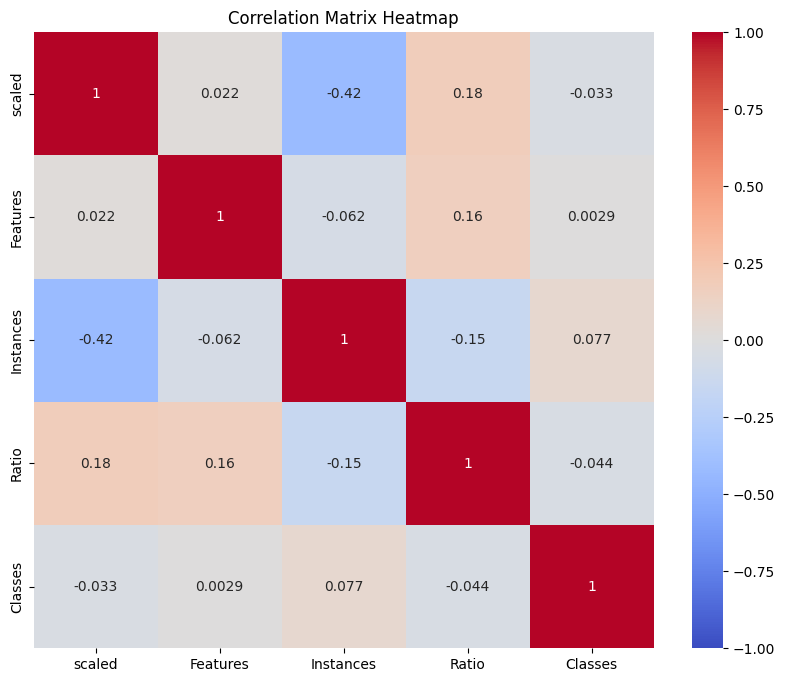

In [20]:
import seaborn as sns

# Filter the DataFrame to keep only the rows for the "GeneticLLM_5min" framework
geneticllm_df = mean_results[mean_results['framework'] == 'GeneticLLM_5min']

# Select the columns of interest
columns_of_interest = ['scaled', 'Features', 'Instances', 'Ratio', 'Classes']
geneticllm_df = geneticllm_df[columns_of_interest]

# Compute the correlation matrix
correlation_matrix = geneticllm_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

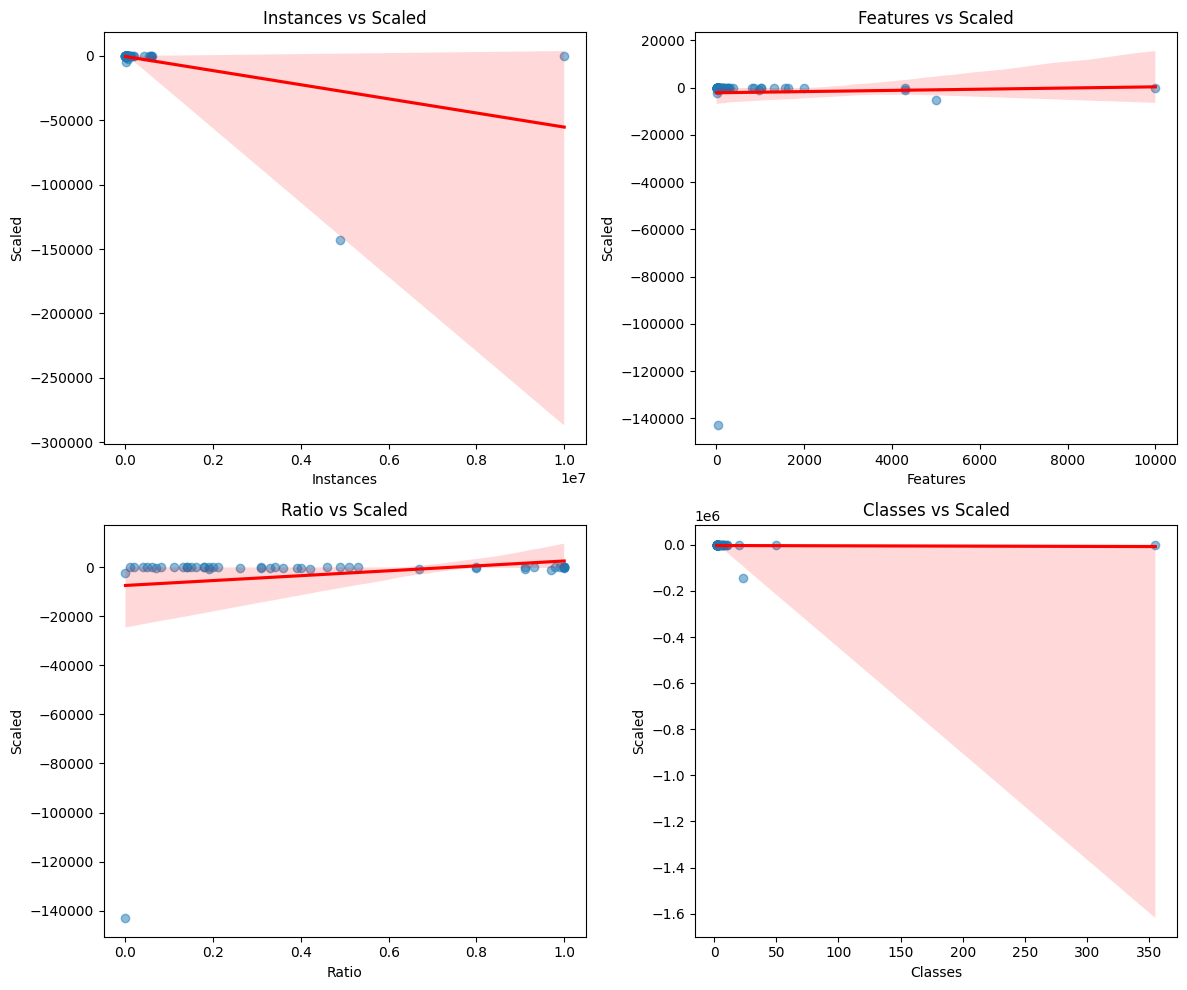

In [21]:
# Assuming mean_results is loaded and filtered as before
filtered_df = mean_results[mean_results['framework'] == 'GeneticLLM_5min']

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure for a 2x2 grid of scatter plots with regression lines
plt.figure(figsize=(12, 10))

# Define columns of interest
columns_of_interest = ['Instances', 'Features', 'Ratio', 'Classes']

# Loop through each characteristic to plot against 'scaled'
for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(2, 2, i)
    
    # Scatter plot with linear regression line to show trends
    sns.regplot(data=filtered_df, x=column, y='scaled', ci=95, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.title(f'{column} vs Scaled')
    plt.xlabel(column)
    plt.ylabel('Scaled')

plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY / 'scaled-vs-columns.png', bbox_inches='tight', dpi=300)
plt.show()


C:\Users\20210595\AppData\Local\Temp\ipykernel_28972\2906858704.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


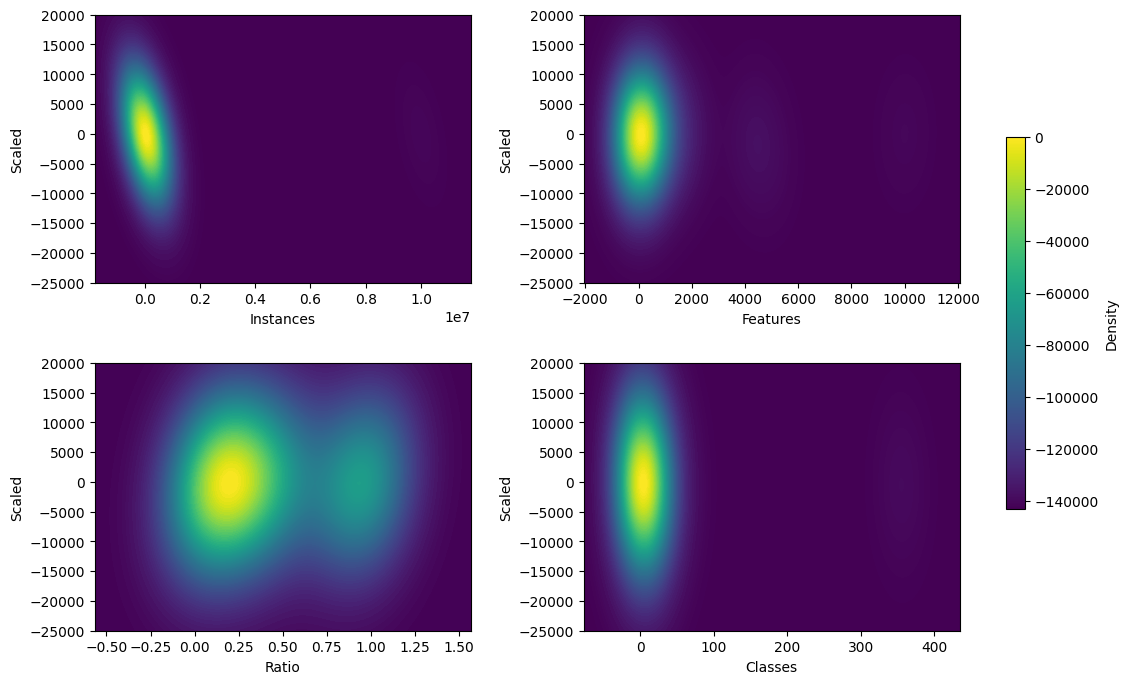

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

plt.figure(figsize=(12, 8))
# Define the grid layout
gs = gridspec.GridSpec(2, 2, wspace=0.3, hspace=0.3)
# Create a shared axis for color bar positioning
norm = plt.Normalize(vmin=filtered_df['scaled'].min(), vmax=filtered_df['scaled'].max())
cmap = "viridis"

# Loop to create each KDE plot in the grid
for i, column in enumerate(columns_of_interest, 1):
    ax = plt.subplot(gs[i - 1])
    sns.kdeplot(
        data=filtered_df, x=column, y='scaled', cmap=cmap, fill=True, thresh=0, levels=100, ax=ax
    )
    ax.set_xlabel(column)
    ax.set_ylabel('Scaled')
    ax.set_ylim(-25000, 20000)

# Add a color bar next to the grid
# Using fig.colorbar for a color bar that aligns with all subplots
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gcf().axes, location='right', fraction=0.02, pad=0.05)
cbar.set_label("Density")

plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY / 'hetmap_density.png', bbox_inches='tight', dpi=300)
plt.show()


C:\Users\20210595\AppData\Local\Temp\ipykernel_28972\1468183569.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


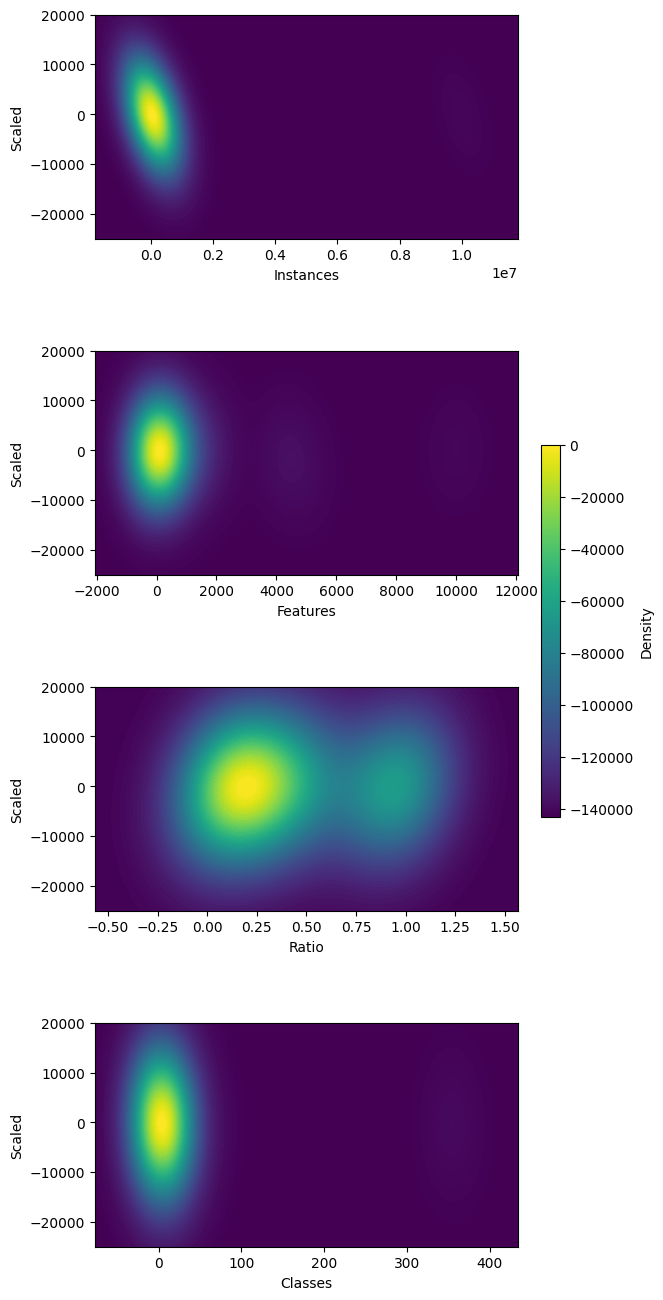

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec

plt.figure(figsize=(6, 16))  # Adjust figsize for single column
# Define the grid layout: 4 rows, 1 column
gs = gridspec.GridSpec(4, 1, hspace=0.5)  # Increased hspace for better spacing between plots
# Create a shared axis for color bar positioning
norm = plt.Normalize(vmin=filtered_df['scaled'].min(), vmax=filtered_df['scaled'].max())
cmap = "viridis"

# Loop to create each KDE plot in the column
for i, column in enumerate(columns_of_interest, 1):
    ax = plt.subplot(gs[i - 1])
    sns.kdeplot(
        data=filtered_df, x=column, y='scaled', cmap=cmap, fill=True, thresh=0, levels=100, ax=ax
    )
    ax.set_xlabel(column)
    ax.set_ylabel('Scaled')
    ax.set_ylim(-25000, 20000)

# Add a color bar next to the plots
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gcf().axes, location='right', fraction=0.04, pad=0.05)
cbar.set_label("Density")

plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY / 'hetmap_density_single.png', bbox_inches='tight', dpi=300)
plt.show()
